In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import torch
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as sk
import zipfile

import torch.nn as nn
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from sklearn.cluster import KMeans

In [ ]:
with zipfile.ZipFile('eyes_pack.zip', 'r') as zip_ref:
  zip_ref.extractall('.')

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Load the face detector
detector = dlib.get_frontal_face_detector()

# Load the facial landmark predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

Using cpu device


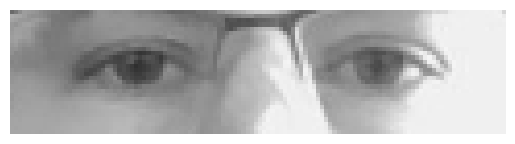

In [3]:
def get_cropped_eyes(gray_image, face):
    # Detect face landmarks
    landmarks = predictor(gray_image, face)
    left_eye = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)], np.int32)
    right_eye = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)], np.int32)
    
    # Calculate the angle of the face
    angle = np.arctan2(right_eye[0][1] - left_eye[0][1], right_eye[0][0] - left_eye[0][0]) * 180 / np.pi
    
    # Rotate the image around the center of the eyes
    (h, w) = gray_image.shape[:2]
    meany = np.mean(np.concatenate([left_eye[:,0],right_eye[:,0]]), dtype=np.float32)
    meanx = np.mean(np.concatenate([left_eye[:,1],right_eye[:,1]]), dtype=np.float32)
    center = (meany//1, meanx//1)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(gray_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
    
    left_eye_rotated = np.dot(M[:, :], np.vstack((left_eye.T, np.ones_like(left_eye[:,0])))).T.astype(np.int32)
    right_eye_rotated = np.dot(M[:, :], np.vstack((right_eye.T, np.ones_like(right_eye[:,0])))).T.astype(np.int32)
    #print(center)
    #print(angle)
    
    # Crop around the eyes
    x_axis = np.concatenate([left_eye_rotated[:,0],right_eye_rotated[:,0]])
    y_axis = np.concatenate([left_eye_rotated[:,1],right_eye_rotated[:,1]])
    x_min = np.min(x_axis)
    x_max = np.max(x_axis)
    y_min = np.min(y_axis)
    y_max = np.max(y_axis)
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    right = round(.25 * x_range) + x_max
    left = x_min - round(.25 * x_range)
    bottom = round(.13 * x_range) + y_max
    top = y_min - round(.13 * x_range)
        
    max_width, max_height = rotated.shape
    right = np.minimum(right, max_width)
    left = np.maximum(left, 0)
    top = np.minimum(top, max_height)
    bottom = np.maximum(bottom, 0)
    # crop the image
    cropped = rotated[top:(bottom + 1), left:(right + 1)]
    
    # Resize the image
    cropped = cv2.resize(cropped, (120, 30))
    return cropped

image = cv2.imread("glasses1_open.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = detector(gray)    
# Iterate over detected faces
for face in faces:
    eyes = get_cropped_eyes(gray, face)

# Display the cropped image
plt.imshow(cv2.cvtColor(eyes, cv2.COLOR_GRAY2RGB))
plt.axis('off')
plt.show()
#cv2.imwrite('./my_glassesopen1b.jpg', cv2.cvtColor(eyes, cv2.COLOR_GRAY2RGB))

In [5]:
# Define data transformations
data_transforms = {
    'train' :   transforms.Compose([
                    transforms.Grayscale(),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.ColorJitter(brightness=0.5, contrast=0.5),
                    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
                    transforms.ToTensor(),  # Convert image to tensor
                    transforms.Normalize((0.5,), (0.5,))  # Normalize image data
                ]),
    'test' : transforms.Compose([
                    transforms.Grayscale(),
                    transforms.ToTensor(),  # Convert image to tensor
                    transforms.Normalize((0.5,), (0.5,))  # Normalize image data
                ]),
}

train_dataset = datasets.ImageFolder(root='./eyes', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root='./eyes', transform=data_transforms['test'])
train_idx, val_idx = sk.train_test_split(np.arange(len(train_dataset)), test_size=0.15, random_state=42)
train_idx.sort()
val_idx.sort()

train_dataset = Subset(train_dataset, train_idx)
test_dataset = Subset(test_dataset, val_idx)
full_dataset = datasets.ImageFolder(root='./eyes', transform=data_transforms['test'])

print(full_dataset.classes)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=len(full_dataset), shuffle=False)

['closed', 'open']


In [6]:
# when doing kmeans clustering, make sure the order of clusters follows the same indexes of samples that produced them
def align_cluster_centers(pred_labels, actual_labels, cluster_centers):
    # Create a dictionary to store the mode of actual labels for each cluster
    cluster_modes = {}

    # Compute the mode of actual labels for each cluster
    for pred_label, actual_label in zip(pred_labels, actual_labels):
        pred_label = pred_label.item()
        actual_label = actual_label.item()
        if pred_label not in cluster_modes :
            cluster_modes[pred_label] = {}
        if actual_label not in cluster_modes[pred_label]:
            cluster_modes[pred_label][actual_label] = 0
        cluster_modes[pred_label][actual_label] += 1

    rearranged_centers = torch.zeros_like(cluster_centers)
    for cluster, mode_dict in cluster_modes.items():
        mode_label = max(mode_dict, key=mode_dict.get)
        rearranged_centers[mode_label] = cluster_centers[cluster]
        
    return rearranged_centers

torch.Size([30, 120, 3])
tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1])


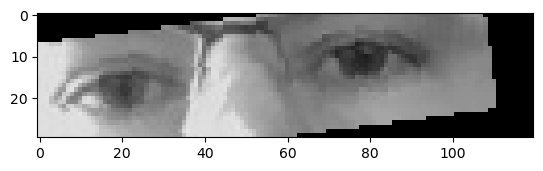

In [7]:

class BlinkDetectionCNN(nn.Module):
    def __init__(self):
        super(BlinkDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 29 * 7, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 output classes: eyes open or closed
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.cluster_centers = None
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 32 * 29 * 7)
        fc1 = self.fc1(x)
        x = self.dropout(self.relu(fc1))
        x = self.fc2(x)
        return x, fc1

    def set_embedding(self, embeddings, labels, pred_labels):
        kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(embeddings.detach().numpy())
        self.cluster_centers = nn.Parameter(torch.from_numpy(kmeans.cluster_centers_)).detach()
        self.cluster_centers = align_cluster_centers(pred_labels, labels, self.cluster_centers)

# Create an instance of the BlinkDetectionCNN model
model = BlinkDetectionCNN()

inputs, classes = next(iter(train_loader))
expanded_tensor = inputs[0].expand(3, -1, -1).permute(1,2,0)
print(expanded_tensor.shape)
image = Image.fromarray(np.uint8((expanded_tensor+1)/2*255))
plt.imshow(image)
#print(inputs)
print(classes)
#model(inputs)


In [8]:
## Phase 1, train fc2 to the categories
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 500
for epoch in range(num_epochs):
    loss_sum = 0
    loss_count = 0
    acc_sum = 0
    test_loss_sum = 0
    test_loss_count = 0
    test_acc_sum = 0

    model.train()
    for data, labels in train_loader:  
        optimizer.zero_grad()
        
        prediction, emb = model(data)
        loss = loss_fn(prediction, labels)
        
        loss_sum += loss.item()
        loss_count += len(labels)
        acc_sum += (prediction.argmax(1) == labels).type(torch.float).sum().item()
        
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            prediction, emb = model(data)
            loss = loss_fn(prediction, labels)
            
            test_loss_sum += loss.item()
            test_loss_count += len(labels)
            test_acc_sum += (prediction.argmax(1) == labels).type(torch.float).sum().item()
    
    #scheduler.step(loss_sum/loss_count)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_sum/loss_count}, Acc: {acc_sum/loss_count}")
        print(f"Epoch {epoch}, Test Loss: {test_loss_sum/test_loss_count}, Acc: {test_acc_sum/test_loss_count}")

Epoch 0, Loss: 0.03026084277940833, Acc: 0.4782608695652174
Epoch 0, Test Loss: 0.14500380754470826, Acc: 0.4
Epoch 10, Loss: 0.02848084594892419, Acc: 0.782608695652174
Epoch 10, Test Loss: 0.13446880578994752, Acc: 0.6
Epoch 20, Loss: 0.024998436803403107, Acc: 0.782608695652174
Epoch 20, Test Loss: 0.13346853256225585, Acc: 0.6
Epoch 30, Loss: 0.026631837305815323, Acc: 0.6086956521739131
Epoch 30, Test Loss: 0.13458274602890014, Acc: 0.4
Epoch 40, Loss: 0.030414819717407227, Acc: 0.5652173913043478
Epoch 40, Test Loss: 0.13316407203674316, Acc: 0.4
Epoch 50, Loss: 0.026448099509529446, Acc: 0.5652173913043478
Epoch 50, Test Loss: 0.13216984272003174, Acc: 0.6
Epoch 60, Loss: 0.02365728824034981, Acc: 0.6956521739130435
Epoch 60, Test Loss: 0.13637380599975585, Acc: 0.6
Epoch 70, Loss: 0.022050608759341034, Acc: 0.6956521739130435
Epoch 70, Test Loss: 0.13729712963104249, Acc: 0.6
Epoch 80, Loss: 0.02220007388488106, Acc: 0.7391304347826086
Epoch 80, Test Loss: 0.1388866662979126, A

In [9]:
def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Correlation')
    plt.title('Correlation Matrix of fc1 Activations')
    plt.xlabel('Samples')
    plt.ylabel('Samples')
    plt.show()

In [10]:
## set embedding centers
model.eval()
with torch.no_grad():
    for data, labels in train_loader:
        prediction, emb = model(data)
        model.set_embedding(emb, labels, prediction.argmax(1))

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, RocCurveDisplay, roc_curve, auc

def show_metrics(emb_model, data_loader):
    emb_model.eval()
    with torch.no_grad():
        for data, labels in data_loader:
            prediction, emb = emb_model(data)
            plot_correlation_matrix(torch.corrcoef(emb))
    
            predictions = prediction.argmax(1)
            accuracy = accuracy_score(labels, predictions) * 100
            f1 = f1_score(labels, predictions, average='macro')
            precision = precision_score(labels, predictions, average='macro')
            recall = recall_score(labels, predictions, average='macro')
            conf_matrix = confusion_matrix(labels, predictions)
            
            # Metrics output
            print("Metrics based on fc2 classification:")
            print(f"Accuracy: {accuracy:.3f}%")
            print(f"F1 Score: {f1:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print("Confusion Matrix:")
            print(conf_matrix)
            print("----")
            
            distances = torch.cdist(emb, emb_model.cluster_centers)
            predictions = distances.min(dim=1)[1].squeeze()
    
            accuracy = accuracy_score(labels, predictions) * 100
            f1 = f1_score(labels, predictions, average='macro')
            precision = precision_score(labels, predictions, average='macro')
            recall = recall_score(labels, predictions, average='macro')
            conf_matrix = confusion_matrix(labels, predictions)
            
            # Metrics output
            print("Metrics based on fc1 clustering:")
            print(f"Accuracy: {accuracy:.3f}%")
            print(f"F1 Score: {f1:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print("Confusion Matrix:")
            print(conf_matrix)


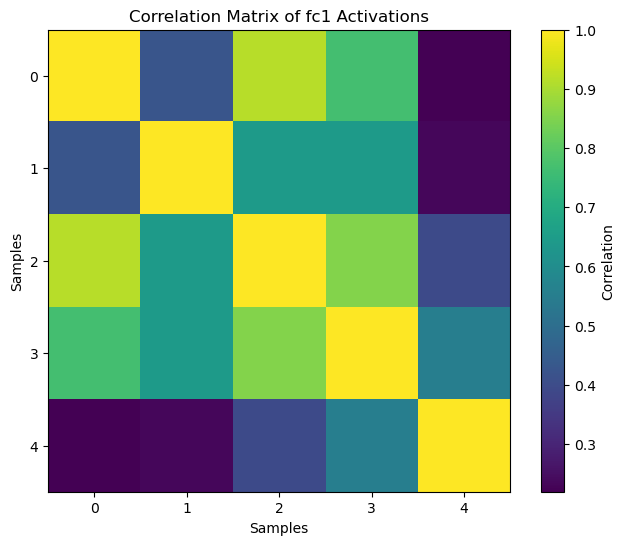

Metrics based on fc2 classification:
Accuracy: 80.000%
F1 Score: 0.762
Precision: 0.875
Recall: 0.750
Confusion Matrix:
[[3 0]
 [1 1]]
----
Metrics based on fc1 clustering:
Accuracy: 60.000%
F1 Score: 0.375
Precision: 0.300
Recall: 0.500
Confusion Matrix:
[[3 0]
 [2 0]]


C:\Users\cdesu\anaconda3\envs\vision3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
show_metrics(model, test_loader)

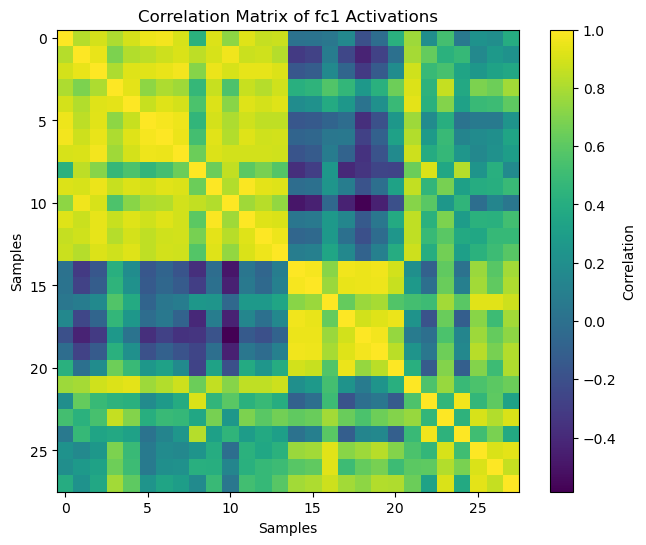

Metrics based on fc2 classification:
Accuracy: 96.429%
F1 Score: 0.964
Precision: 0.967
Recall: 0.964
Confusion Matrix:
[[14  0]
 [ 1 13]]
----
Metrics based on fc1 clustering:
Accuracy: 71.429%
F1 Score: 0.689
Precision: 0.818
Recall: 0.714
Confusion Matrix:
[[14  0]
 [ 8  6]]


In [16]:
show_metrics(model, full_loader)

In [17]:
## Phase 2, train fc1 to the cluster centers
loss_fn = nn.MSELoss()
num_epochs = 500
for epoch in range(num_epochs):
    loss_sum = 0
    loss_count = 0
    acc_sum = 0
    test_loss_sum = 0
    test_loss_count = 0
    test_acc_sum = 0

    model.train()
    for data, labels in train_loader:  
        optimizer.zero_grad()
        
        prediction, emb = model(data)

        loss = loss_fn(emb, model.cluster_centers[labels].squeeze())
        
        loss_sum += loss.item()
        loss_count += len(labels)
        
        distances = torch.cdist(emb, model.cluster_centers)
        pred_labels = distances.min(dim=1)[1]
        testY = labels.squeeze()            
        for i in range(len(pred_labels)):
            if pred_labels[i] == testY[i]:
                acc_sum += 1
        
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            prediction, emb = model(data)   

            loss = loss_fn(emb, model.cluster_centers[labels].squeeze())
            
            test_loss_sum += loss.item()
            test_loss_count += len(labels)
            
            distances = torch.cdist(emb, model.cluster_centers)
            pred_labels = distances.min(dim=1)[1]
            testY = labels.squeeze()            
            for i in range(len(pred_labels)):
                if pred_labels[i] == testY[i]:
                    test_acc_sum += 1
    
    #scheduler.step(loss_sum/loss_count)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_sum/loss_count}, Acc: {acc_sum/loss_count}")
        print(f"Epoch {epoch}, Test Loss: {test_loss_sum/test_loss_count}, Acc: {test_acc_sum/test_loss_count}")

Epoch 0, Loss: 0.042835772037506104, Acc: 0.6956521739130435
Epoch 0, Test Loss: 0.16994364261627198, Acc: 0.8
Epoch 10, Loss: 0.02433352625888327, Acc: 0.7391304347826086
Epoch 10, Test Loss: 0.10558869838714599, Acc: 1.0
Epoch 20, Loss: 0.019672900438308716, Acc: 0.782608695652174
Epoch 20, Test Loss: 0.0824161171913147, Acc: 1.0
Epoch 30, Loss: 0.01998838264009227, Acc: 0.7391304347826086
Epoch 30, Test Loss: 0.07910611033439637, Acc: 1.0
Epoch 40, Loss: 0.018806268339571747, Acc: 0.7391304347826086
Epoch 40, Test Loss: 0.07450082302093505, Acc: 0.8
Epoch 50, Loss: 0.01711721394373023, Acc: 0.7391304347826086
Epoch 50, Test Loss: 0.07174440622329711, Acc: 1.0
Epoch 60, Loss: 0.016826233138208805, Acc: 0.8260869565217391
Epoch 60, Test Loss: 0.067805016040802, Acc: 0.8
Epoch 70, Loss: 0.016442300184913303, Acc: 0.8260869565217391
Epoch 70, Test Loss: 0.0644795536994934, Acc: 0.8
Epoch 80, Loss: 0.01388142290322677, Acc: 0.9130434782608695
Epoch 80, Test Loss: 0.06376037001609802, Acc

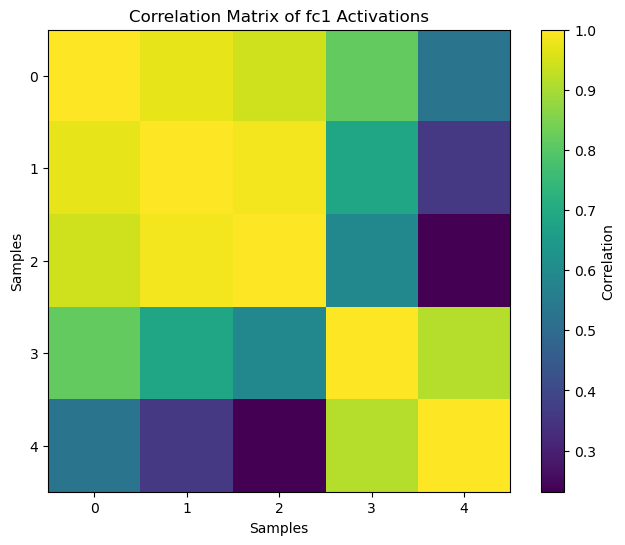

Metrics based on fc2 classification:
Accuracy: 80.000%
F1 Score: 0.800
Precision: 0.833
Recall: 0.833
Confusion Matrix:
[[2 1]
 [0 2]]
----
Metrics based on fc1 clustering:
Accuracy: 100.000%
F1 Score: 1.000
Precision: 1.000
Recall: 1.000
Confusion Matrix:
[[3 0]
 [0 2]]


In [18]:
show_metrics(model, test_loader)

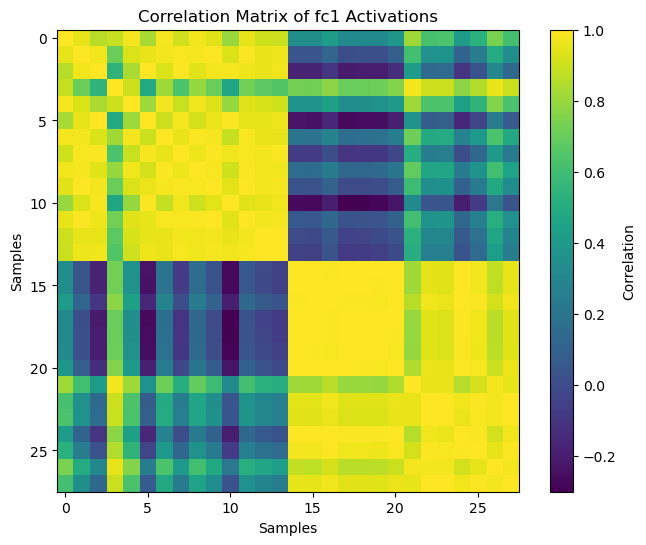

Metrics based on fc2 classification:
Accuracy: 92.857%
F1 Score: 0.928
Precision: 0.938
Recall: 0.929
Confusion Matrix:
[[12  2]
 [ 0 14]]
----
Metrics based on fc1 clustering:
Accuracy: 100.000%
F1 Score: 1.000
Precision: 1.000
Recall: 1.000
Confusion Matrix:
[[14  0]
 [ 0 14]]


In [19]:
show_metrics(model, full_loader)

In [20]:
transform_process = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize image data
])

tensor([1])
tensor([[-2.2693,  1.4788]], grad_fn=<AddmmBackward0>)


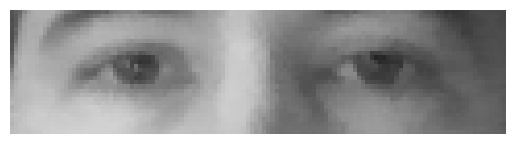

In [21]:
image = cv2.imread("me_open2.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = detector(gray)    
# Iterate over detected faces
for face in faces:
    eyes = get_cropped_eyes(gray, face)
    _, emb = model(transform_process(eyes).unsqueeze(0))
    distances = torch.cdist(emb, model.cluster_centers)
    pred_labels = distances.min(dim=1)[1]
    print(pred_labels)
    print(_)
    #cv2.imshow("Frame", cv2.cvtColor(eyes, cv2.COLOR_BGR2RGB))
    plt.imshow(cv2.cvtColor(eyes, cv2.COLOR_GRAY2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
#torch.save(model.state_dict(), "base_model_project.pt")

In [952]:
#model.load_state_dict(torch.load("base_model_project.pt"))

<All keys matched successfully>

In [1009]:
def decode_morse_code(morse_code):
    # Lookup table or dictionary to decode Morse code to English letters
    morse_to_eng = {
        '.-': 'A', '-...': 'B', '-.-.': 'C', '-..': 'D', '.': 'E',
        '..-.': 'F', '--.': 'G', '....': 'H', '..': 'I', '.---': 'J',
        '-.-': 'K', '.-..': 'L', '--': 'M', '-.': 'N', '---': 'O',
        '.--.': 'P', '--.-': 'Q', '.-.': 'R', '...': 'S', '-': 'T',
        '..-': 'U', '...-': 'V', '.--': 'W', '-..-': 'X', '-.--': 'Y',
        '--..': 'Z'
    }
    return morse_to_eng.get(morse_code, '')

def inference_video(video_path, dot_threshold=5, end_threshold=10, precropped_video=False):
    
    cap = cv2.VideoCapture(video_path)
    codec = 'MJPG'
    #fourcc = cv2.VideoWriter_fourcc(*codec)
    #out = cv2.VideoWriter('morse_spaceg.avi', fourcc, 20.0, (120,30))
    empty_count = 0
    prv_letter = '_'
    words = ''
    
    prv_state = 1
    state_count = 0
    symbols = []
    
    while True:
        ret, frame = cap.read()
        if ret:            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)
            if precropped_video:
                faces = [1] # force face loop
            empty_count += 1
            # Iterate over detected faces
            for face in faces:
                empty_count = 0
                
                if not precropped_video:
                    eyes = get_cropped_eyes(gray, face)
                else:
                    eyes = gray # use the precropped frame
                    
                with torch.no_grad():
                    data_in = transform_process(eyes).unsqueeze(0)                    
                    _, emb = model(data_in)
                    distances = torch.cdist(emb, model.cluster_centers)
                    open_shut = distances.min(dim=1)[1].squeeze()
                                    
                if open_shut == 0: #closed
                    if prv_state == 1:
                        #newly closed
                        state_count = 0
                    else:
                        #continued close
                        state_count += 1
                else: #open
                    if prv_state == 0:
                        #end of close, interpret
                        if state_count < dot_threshold:
                            #dot
                            symbols.append('.')
                        else:
                            #dash
                            symbols.append('-')
                        state_count = 0
                    else:
                        #still open
                        state_count += 1                        
                        if state_count > end_threshold:
                            state_count = 0
                            if len(symbols) > 0:
                                #find letter
                                code = ''.join(symbols)
                                symbols = []
                                letter = decode_morse_code(code)
                                words += letter
                                prv_letter = letter
                            else:
                                #word space
                                if prv_letter != '_':
                                    words += '_'
                                    prv_letter = '_'
                                    
                            ## if lrcn worked then the below may handle decoding
                            #if len(frame_buffer) > 0:
                            #    #find letter
                            #    code = torch.stack(frame_buffer).permute(1,0,2,3,4)
                            #    output = lrcn(code[:,:-10])
                            #    letter = output.argmax(dim=1, keepdim=False)
                            #    words2 += video_dataset.classes[letter]
                            #    prv_letter2 = letter
                                    
                prv_state = open_shut     
                if len(words) > 20:
                    words = '' #clear the clutter
                    
                ## frame = cv2.resize(frame,(800,100)) # resize precropped training videos
                font                   = cv2.FONT_HERSHEY_SIMPLEX
                bottomLeftCornerOfText = (20,20)
                fontScale              = 0.6
                fontColor              = (255)
                thickness              = 1
                lineType               = 2

                blink = "O"
                if open_shut == 0:
                    blink = "-"
                text = f"{blink} :: {words}"
                
                cv2.putText(frame, text, 
                    bottomLeftCornerOfText, 
                    font, 
                    fontScale,
                    fontColor,
                    thickness,
                    lineType)
                #out.write(cv2.cvtColor(eyes, cv2.COLOR_GRAY2BGR))
                
                cv2.imshow("Frame", cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                
        else:
            empty_count += 1
            
        if cv2.waitKey(1) & 0xFF == ord('q') or empty_count > 300:
            if empty_count > 50:
                print(f"empty count: {empty_count}")
            break
    cap.release()
    #out.release()
    cv2.destroyAllWindows()

#inference_video("./morse/morse_c.avi", 9, 8, precropped_video=True)
inference_video(0)